In [1]:
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels


In [2]:
import sys
sys.path.append('/home/john/caffe-master/python/')
sys.path.append('/home/john/Desktop/TwoStage/Model/')
sys.path.append('/usr/lib/python2.7/dist-packages/')

import cv2
import numpy as np

import caffe

X_train, y_train = load_mnist('./Data/Raw/', kind='train')
X_test, y_test = load_mnist('./Data/Raw/', kind='t10k')

Feature extraction via pre-trained model

In [3]:
MODEL_FILE = './Pretrained/lenet.prototxt'
PRETRAINED = './Pretrained/lenet_iter_10000.caffemodel'

net = caffe.Net(MODEL_FILE, PRETRAINED, caffe.TEST)
caffe.set_mode_gpu()

X_train_feature = []
for i in range(len(X_train)):
    input_image = np.resize(X_train[i, :], (28, 28))
    
    input_image = input_image[np.newaxis, np.newaxis, ...]
    input_image = np.repeat(input_image, 64, axis=0)

    net.blobs["data"].data[...] = input_image
    net.forward()
    data = net.blobs["ip1"].data
    
    feature = np.mean(data, axis=0)
    X_train_feature.append(feature)
    
X_test_feature = []
for i in range(len(X_test)):
    input_image = np.resize(X_test[i, :], (28, 28))
    
    input_image = input_image[np.newaxis, np.newaxis, ...]
    input_image = np.repeat(input_image, 64, axis=0)

    net.blobs["data"].data[...] = input_image
    net.forward()
    data = net.blobs["ip1"].data
    
    feature = np.mean(data, axis=0)
    X_test_feature.append(feature)
    

Feature visulization

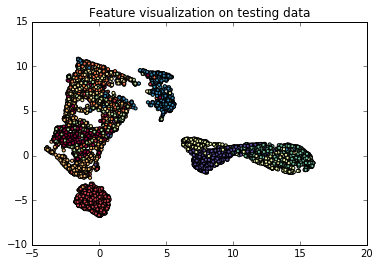

In [11]:
import umap
import matplotlib.pyplot as plt
trans = umap.UMAP(n_neighbors=10, random_state=40).fit(X_test_feature)
plt.scatter(trans.embedding_[:,0], trans.embedding_[:,1], s=10, c=y_test, cmap='Spectral')
plt.title('Feature visualization on testing data')
plt.show()

Feature extraction + Linear SVM

In [5]:
from sklearn import linear_model
from sklearn.metrics import accuracy_score

clf = linear_model.SGDClassifier()
clf.fit(X_train_feature, y_train)

y_test_prediction = clf.predict(X_test_feature)

print "Classification accuracy is: %.5f" % accuracy_score(y_test_prediction, y_test)

/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Classification accuracy is: 0.81280


Fine-tuning pretrained model

In [ ]:
import caffe

solver_finetune = caffe.SGDSolver('./Finetuned/lenet_solver_ft.prototxt')
solver_finetune.net.copy_from('./Pretrained/lenet_iter_10000.caffemodel')
solver_finetune.solve()

In [6]:
from sklearn.metrics import accuracy_score

MODEL_FILE = './Finetuned/lenet_ft.prototxt'
PRETRAINED = './Finetuned/lenet_ft_iter_100000.caffemodel'

net = caffe.Net(MODEL_FILE, PRETRAINED, caffe.TEST)
caffe.set_mode_gpu()

y_test_prediction = []
for i in range(len(X_test)):
    input_image = np.resize(X_test[i, :], (28, 28))
    
    input_image = input_image[np.newaxis, np.newaxis, ...]
#    input_image = np.repeat(input_image, 3, axis=1)

    net.blobs["data"].data[...] = input_image

    net.forward()
    data = net.blobs["prob"].data
    prediction = data
    
    y_test_prediction.append(np.argmax(prediction))
    
print "Classification accuracy is: %.5f" % accuracy_score(y_test_prediction, y_test)

Classification accuracy is: 0.83030


In [ ]:
import caffe

solver_scratch = caffe.SGDSolver('./Finetuned/lenet_solver_scratch.prototxt')
solver_scratch.solve()

In [7]:
from sklearn.metrics import accuracy_score

MODEL_FILE = './Finetuned/lenet_ft.prototxt'
PRETRAINED = './Finetuned/lenet_scratch_iter_100000.caffemodel'

net = caffe.Net(MODEL_FILE, PRETRAINED, caffe.TEST)
caffe.set_mode_gpu()

y_test_prediction = []
for i in range(len(X_test)):
    input_image = np.resize(X_test[i, :], (28, 28))
    
    input_image = input_image[np.newaxis, np.newaxis, ...]
#    input_image = np.repeat(input_image, 3, axis=1)

    net.blobs["data"].data[...] = input_image

    net.forward()
    data = net.blobs["prob"].data
    prediction = data
    
    y_test_prediction.append(np.argmax(prediction))
    
print "Classification accuracy is: %.5f" % accuracy_score(y_test_prediction, y_test)

Classification accuracy is: 0.84470


In [ ]:
import caffe

solver_finetune_all = caffe.SGDSolver('./Finetuned_all/lenet_solver_ft.prototxt')
solver_finetune_all.net.copy_from('./Pretrained/lenet_iter_10000.caffemodel')
solver_finetune_all.solve()

In [8]:
from sklearn.metrics import accuracy_score

MODEL_FILE = './Finetuned/lenet_ft.prototxt'
PRETRAINED = './Finetuned/lenet_ft_all_iter_100000.caffemodel'

net = caffe.Net(MODEL_FILE, PRETRAINED, caffe.TEST)
caffe.set_mode_gpu()

y_test_prediction = []
for i in range(len(X_test)):
    input_image = np.resize(X_test[i, :], (28, 28))
    
    input_image = input_image[np.newaxis, np.newaxis, ...]
#    input_image = np.repeat(input_image, 3, axis=1)

    net.blobs["data"].data[...] = input_image

    net.forward()
    data = net.blobs["prob"].data
    prediction = data
    
    y_test_prediction.append(np.argmax(prediction))
    
print "Classification accuracy is: %.5f" % accuracy_score(y_test_prediction, y_test)

Classification accuracy is: 0.83360
